In [48]:
# install libraries/packages/modules 

!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-rvhwvmkd
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-rvhwvmkd


In [49]:
# Download Dataset

!git clone https://github.com/parth1620/object-localization-dataset.git

fatal: destination path 'object-localization-dataset' already exists and is not an empty directory.


In [50]:
import pandas as pd 
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [51]:
import sys
sys.path.append("/content/object-localization-dataset")

In [73]:
csv_file = "/content/object-localization-dataset/train.csv"
data_dir= "/content/object-localization-dataset/"

device= "cuda"
BATCH_SIZE= 16
IMG_SIZE= 140

LR= 0.001
EPOCHS= 40
model_name= "efficientnet_b0"

NUM_COR=4

Load

In [53]:
df= pd.read_csv(csv_file)
df

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant
...,...,...,...,...,...,...,...,...
181,train_images/eggplant_62.jpg,67,22,177,215,227,227,eggplant
182,train_images/cucumber_45.jpg,11,31,217,208,227,227,cucumber
183,train_images/mushroom_37.jpg,93,13,158,193,227,227,mushroom
184,train_images/eggplant_44.jpg,21,59,192,171,227,227,eggplant


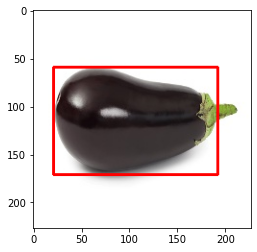

In [54]:
row = df.iloc[184] #select one row
img = cv2.imread(data_dir + row.img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

pt1= (row.xmin, row.ymin)
pt2 = (row.xmax, row.ymax)

bnd_box_img = cv2.rectangle(img, pt1, pt2, (255, 0, 0),2)
plt.imshow(bnd_box_img)


In [55]:
train_df, valid_df = train_test_split(df, test_size=0.20, random_state= 42)

Augmentations

In [56]:
import albumentations as A

In [57]:
train_augs = A.Compose([
                        A.Resize(IMG_SIZE, IMG_SIZE),
                        A.HorizontalFlip(p=0.5),
                        A.VerticalFlip(p=0.5),
                        A.Rotate()
], bbox_params= A.BboxParams(format= "pascal_voc", label_fields = ["class_labels"]))

valid_augs = A.Compose([
                        A.Resize(IMG_SIZE, IMG_SIZE)],
                       bbox_params= A.BboxParams(format = "pascal_voc", label_fields = ["class_labels"]))

In [58]:
class ObjLocDataset(torch.utils.data.Dataset):

  def __init__(self, df, augmentations = None):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self,idx):

    row = self.df.iloc[idx]

    xmin = row.xmin
    ymin = row.ymin
    xmax = row.xmax
    ymax = row.ymax

    bbox = [[xmin, ymin, xmax, ymax]]

    img_path= data_dir + row.img_path
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if self.augmentations:
      data = self.augmentations(image = img, bboxes = bbox, class_labels = [None])
      img = data["image"]
      bbox = data["bboxes"][0]

    img = torch.from_numpy(img).permute(2, 0, 1) / 255.0 #(h,w,c) -> (c,h,w)
    bbox = torch.Tensor(bbox)

    return img, bbox

In [59]:
trainset = ObjLocDataset(train_df, train_augs)
validset = ObjLocDataset(valid_df, valid_augs)

In [60]:
print(f"Total examples in the trainset: {len(trainset)}")
print(f"Total examples in the validset: {len(validset)}")

Total examples in the trainset: 148
Total examples in the validset: 38


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


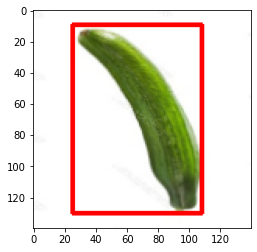

In [61]:
img, bbox = trainset[6] #pass an index

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1,2,0).numpy(), pt1, pt2, (255, 0, 0), 2)
plt.imshow(bnd_img)

Load dataset into batches

In [62]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = torch.utils.data.DataLoader(validset, batch_size = BATCH_SIZE, shuffle = False)

In [63]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 10
Total no. batches in validloader : 3


In [64]:
for images, bboxes in trainloader:
  break;

print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([16, 3, 140, 140])
Shape of one batch bboxes : torch.Size([16, 4])


In [65]:
from torch import nn
import timm





In [66]:
class ObjLocModel(nn.Module):

  def __init__(self):
    super(ObjLocModel, self).__init__()

    self.backbone = timm.create_model(model_name, pretrained = True, num_classes= 4) #classes for xmin, xmax, ymin, ymax


  def forward(self, images, gt_bboxes = None):

    bboxes = self.backbone(images)

    if gt_bboxes != None:
      loss = nn.MSELoss()(bboxes, gt_bboxes)
      return bboxes, loss
      
    return bboxes

In [67]:

model = ObjLocModel()
model.to(device) # insert ; at end to mute the output

ObjLocModel(
  (backbone): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): SiLU(inplace=True)
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act1): SiLU(inplace=True)
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=T

In [68]:
random_img = torch.rand(1,3,140,140).to(device)
model(random_img).shape

torch.Size([1, 4])

Create train and Eval Function

In [69]:
def train_fn(model, dataloader, optimizer):
  total_loss = 0.0
  model.train() #dropout ON

  for data in tqdm(dataloader):

    images, gt_bboxes = data
    images, gt_bboxes = images.to(device), gt_bboxes.to(device)

    bboxes, loss = model(images, gt_bboxes)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

In [70]:
def eval_fn(model, dataloader):
  total_loss = 0.0
  model.eval() #dropout OFF

  with torch.no_grad():
    for data in tqdm(dataloader):

      images, gt_bboxes = data
      images, gt_bboxes = images.to(device), gt_bboxes.to(device)

      bboxes, loss = model(images, gt_bboxes)
      total_loss += loss.item()

  return total_loss / len(dataloader)

Training Loop

In [71]:
optimizer = torch.optim.Adam(model.parameters(), lr= LR)

In [75]:
best_valid_loss = np.Inf

for i in range(EPOCHS):

  train_loss = train_fn(model, trainloader, optimizer)
  valid_loss = eval_fn(model, validloader)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), "best_model.pt")
    print("WEIGHTS-ARE-SAVED")
    best_valid_loss = valid_loss
  
  print(f"Epoch; {i + 1} train loss: {train_loss} valid loss: {valid_loss}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch; 1 train loss: 532.9815856933594 valid loss: 148.55277506510416


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch; 2 train loss: 388.1635467529297 valid loss: 123.58340454101562


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch; 3 train loss: 302.3565216064453 valid loss: 256.80126953125


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch; 4 train loss: 219.27973480224608 valid loss: 149.42540232340494


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch; 5 train loss: 204.44709014892578 valid loss: 120.83062489827473


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch; 6 train loss: 157.55949935913085 valid loss: 176.4534912109375


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch; 7 train loss: 127.78448486328125 valid loss: 113.20570882161458


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch; 8 train loss: 107.4972412109375 valid loss: 116.42317708333333


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch; 9 train loss: 107.16127319335938 valid loss: 111.73616282145183


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch; 10 train loss: 90.11278610229492 valid loss: 107.6609369913737


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch; 11 train loss: 71.61401672363282 valid loss: 113.71865590413411


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch; 12 train loss: 77.51980056762696 valid loss: 118.12139383951823


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch; 13 train loss: 76.48068313598633 valid loss: 112.01507059733073


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch; 14 train loss: 61.61881637573242 valid loss: 108.38914235432942


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch; 15 train loss: 63.74362411499023 valid loss: 69.75342814127605


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch; 16 train loss: 70.39378128051757 valid loss: 71.25138092041016


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch; 17 train loss: 70.10632514953613 valid loss: 62.29941177368164


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch; 18 train loss: 60.80783042907715 valid loss: 95.3488032023112


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch; 19 train loss: 38.69572525024414 valid loss: 67.15283966064453


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch; 20 train loss: 44.27279205322266 valid loss: 79.82462565104167


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch; 21 train loss: 57.0031005859375 valid loss: 64.6745491027832


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch; 22 train loss: 49.155110931396486 valid loss: 68.39053090413411


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch; 23 train loss: 52.71832466125488 valid loss: 99.7200215657552


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch; 24 train loss: 51.708174324035646 valid loss: 56.603861490885414


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch; 25 train loss: 53.53681602478027 valid loss: 94.25002034505208


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch; 26 train loss: 55.41590347290039 valid loss: 78.11928812662761


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch; 27 train loss: 39.08435592651367 valid loss: 69.34869639078777


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch; 28 train loss: 46.97321701049805 valid loss: 48.41131083170573


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch; 29 train loss: 39.194976043701175 valid loss: 72.49242273966472


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch; 30 train loss: 66.19770069122315 valid loss: 65.53669102986653


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch; 31 train loss: 56.54373893737793 valid loss: 110.68185933430989


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch; 32 train loss: 48.443817138671875 valid loss: 65.7411740620931


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch; 33 train loss: 41.627346420288085 valid loss: 69.30867767333984


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch; 34 train loss: 45.77033748626709 valid loss: 83.76056798299153


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch; 35 train loss: 31.391803169250487 valid loss: 61.83595275878906


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch; 36 train loss: 40.8318998336792 valid loss: 108.6162109375


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch; 37 train loss: 36.43766498565674 valid loss: 57.67274475097656


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch; 38 train loss: 47.98314914703369 valid loss: 64.46989440917969


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch; 39 train loss: 46.10568218231201 valid loss: 88.13033930460612


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch; 40 train loss: 32.775567817687985 valid loss: 65.20640055338542


Inference

In [76]:
import utils

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


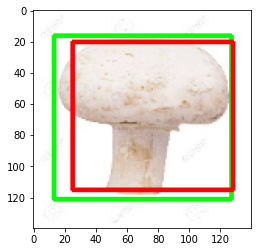

In [78]:
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

with torch.no_grad():

  image, gt_bbox = validset[1] # (bs, c, h, w)
  image = image.unsqueeze(0).to(device) #(bs, c, h, w)
  out_bbox = model(image)

  utils.compare_plots(image, gt_bbox, out_bbox)

